## New Cross Validation Scheme
- Just doing cross validation on the whole test data and then averaging these to submit to the leaderboard has a few flaws:
    - potential overfit to leaderboard since we are using that for model validation
    - potential data leakage in each fold
    
- to do a proper model validation, it is good practice to have an extra holdout set to test the model predictions. If the holdout set predictions are not too different from the CV performance then we can be more confident on generalisation to new data
- disadvantage is less data for training the model (we can't do this well if we have a small dataset)

In [52]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import datetime
import missingno as msno
import lightgbm as lgb
import xgboost as xgb
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, TimeSeriesSplit, train_test_split,StratifiedKFold
import gc
from statistics import mean
import pickle

# Any results you write to the current directory are saved as output.

### Setup Cross Validation
1. Divide Train set in subsets (Cross Validation folds + Holdout set (separate from leaderboard test set))
2. Define Validation Metric (in our case it is ROC-AUC)
3. Stop training when Validation metric stops improving
4. Take average of each fold's prediction for the Local Test set.

In [57]:
train_full = pd.read_pickle('data/train_feat.pkl')
test_full = pd.read_pickle('data/test_feat.pkl')

# Label Encoding for categoricals
for f in test_full.columns:
    if train_full[f].dtype=='object' or test_full[f].dtype=='object': 
        train_full[f] = train_full[f].fillna('unseen_before_label')
        test_full[f]  = test_full[f].fillna('unseen_before_label')
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_full[f].values) + list(test_full[f].values))
        train_full[f] = lbl.transform(list(train_full[f].values))
        test_full[f] = lbl.transform(list(test_full[f].values)) 

# Fill NA's for numerics
train_full = train_full.fillna(-999)
test_full = test_full.fillna(-999)

Use the 200 features chosen by the RFE feature selection previously

In [58]:
with open('data/rfe_features_200.pkl', 'rb') as f:
    rfe_feature = pickle.load(f)
features_columns = rfe_feature

In [59]:
# X = train_full[features_columns]
# y = train_full['isFraud']

# train_full=train_full.sort_values('TransactionDT',ascending=True).reset_index(drop=True)

# # Create Holdout Set using a time series split
# X = train_full[features_columns].iloc[:int(len(train_full)*0.85)]
# X_holdout = train_full[features_columns].iloc[int(len(train_full)*0.85):]
# y = train_full['isFraud'].iloc[:int(len(train_full)*0.85)]
# y_holdout =train_full['isFraud'].iloc[int(len(train_full)*0.85):]

# Split holdout as 15% of the train set
X, X_holdout, y, y_holdout = train_test_split(train_full[features_columns], train_full['isFraud'], 
                                              test_size=0.15, random_state=42, shuffle=True,
                                              stratify = train_full['isFraud'])

del train_full
gc.collect()

188

In [63]:
params = {
                    'objective':'binary',
                    'boosting_type':'gbdt',
                    'metric':'auc',
                    'n_jobs':-1,
                    'learning_rate':0.05, # speed up the learning rate a bit - might sacrifice a bit of accuracy
                    'num_leaves':2**8, # reduce number of leaves to reduce overfitting
                    'max_depth': 8, # max_depth should be constrained, -1 would mean unconstrained
                    'tree_learner':'serial',
                    'colsample_bytree': 0.7,
                    'subsample_freq':1,
                    'subsample':0.7,
                    'n_estimators':1000,
                    'max_bin':255, # less bins if overfitting
                    'verbose':-1,
                    'seed': 2019,
                    'early_stopping_rounds':100,
#                     'lambda_l1':5,
#                     'lambda_l2':5,
                } 

In [64]:
NFOLDS =5
folds = StratifiedKFold(n_splits=NFOLDS,random_state=123,shuffle=True) # split by stratified folds
# folds = TimeSeriesSplit(n_splits=NFOLDS) # split by time - try timeseries split, perhaps less overfitting? result: worse overfitting

aucs = []
clfs=[]
pred_len = len(test_full)
prediction = np.zeros(pred_len)

for fold, (trn_idx, test_idx) in enumerate(folds.split(X,y)):
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(data=X.iloc[trn_idx], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(data=X.iloc[test_idx], label=y.iloc[test_idx])
    clf = lgb.train(params, 
                    trn_data, 
                    valid_sets = [trn_data, val_data], 
                    verbose_eval=200)
    
    print('AUC for validation fold {}: {}'.format(fold+1, clf.best_score['valid_1']['auc']))
    aucs.append(clf.best_score['valid_1']['auc'])
    
    holdout_pred = clf.predict(X_holdout)
    print('AUC for holdout set - fold ', roc_auc_score(y_holdout, holdout_pred))
    
    prediction += clf.predict(test_full[features_columns])

print("Cross Validation AUC: ", sum(aucs)/NFOLDS)
final_predictions = prediction/NFOLDS

Training on fold 1


C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.97244	valid_1's auc: 0.945786
[400]	training's auc: 0.987268	valid_1's auc: 0.956908
[600]	training's auc: 0.994567	valid_1's auc: 0.963144
[800]	training's auc: 0.997653	valid_1's auc: 0.966101
[1000]	training's auc: 0.999056	valid_1's auc: 0.968
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.999056	valid_1's auc: 0.968
AUC for validation fold 1: 0.9680004191858358
AUC for holdout set - fold  0.9703543618371971
Training on fold 2


C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.973138	valid_1's auc: 0.947775
[400]	training's auc: 0.987888	valid_1's auc: 0.957942
[600]	training's auc: 0.994537	valid_1's auc: 0.963595
[800]	training's auc: 0.997461	valid_1's auc: 0.96684
[1000]	training's auc: 0.999006	valid_1's auc: 0.96887
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.999006	valid_1's auc: 0.96887
AUC for validation fold 2: 0.9688700834690309
AUC for holdout set - fold  0.9691030402404498
Training on fold 3


C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.971607	valid_1's auc: 0.943833
[400]	training's auc: 0.988117	valid_1's auc: 0.957043
[600]	training's auc: 0.994693	valid_1's auc: 0.963237
[800]	training's auc: 0.997529	valid_1's auc: 0.96657
[1000]	training's auc: 0.998987	valid_1's auc: 0.968241
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.998987	valid_1's auc: 0.968241
AUC for validation fold 3: 0.9682410490855995
AUC for holdout set - fold  0.9690047158055402
Training on fold 4


C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.972973	valid_1's auc: 0.947986
[400]	training's auc: 0.987609	valid_1's auc: 0.959901
[600]	training's auc: 0.994292	valid_1's auc: 0.966177
[800]	training's auc: 0.997448	valid_1's auc: 0.969346
[1000]	training's auc: 0.999009	valid_1's auc: 0.971202
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.999009	valid_1's auc: 0.971202
AUC for validation fold 4: 0.9712019677546414
AUC for holdout set - fold  0.9690379234706802
Training on fold 5


C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\martin.cheung\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.972473	valid_1's auc: 0.947538
[400]	training's auc: 0.987744	valid_1's auc: 0.959446
[600]	training's auc: 0.994676	valid_1's auc: 0.965383
[800]	training's auc: 0.997664	valid_1's auc: 0.968362
[1000]	training's auc: 0.998973	valid_1's auc: 0.969838
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.998973	valid_1's auc: 0.969838
AUC for validation fold 5: 0.9698377712366513
AUC for holdout set - fold  0.9712763171501211
Cross Validation AUC:  0.9692302581463519


The average AUC for the timeseries split is much lower, and the LB score is a lower too. Might not be the correct CV scheme for time series as well. Still inconclusive

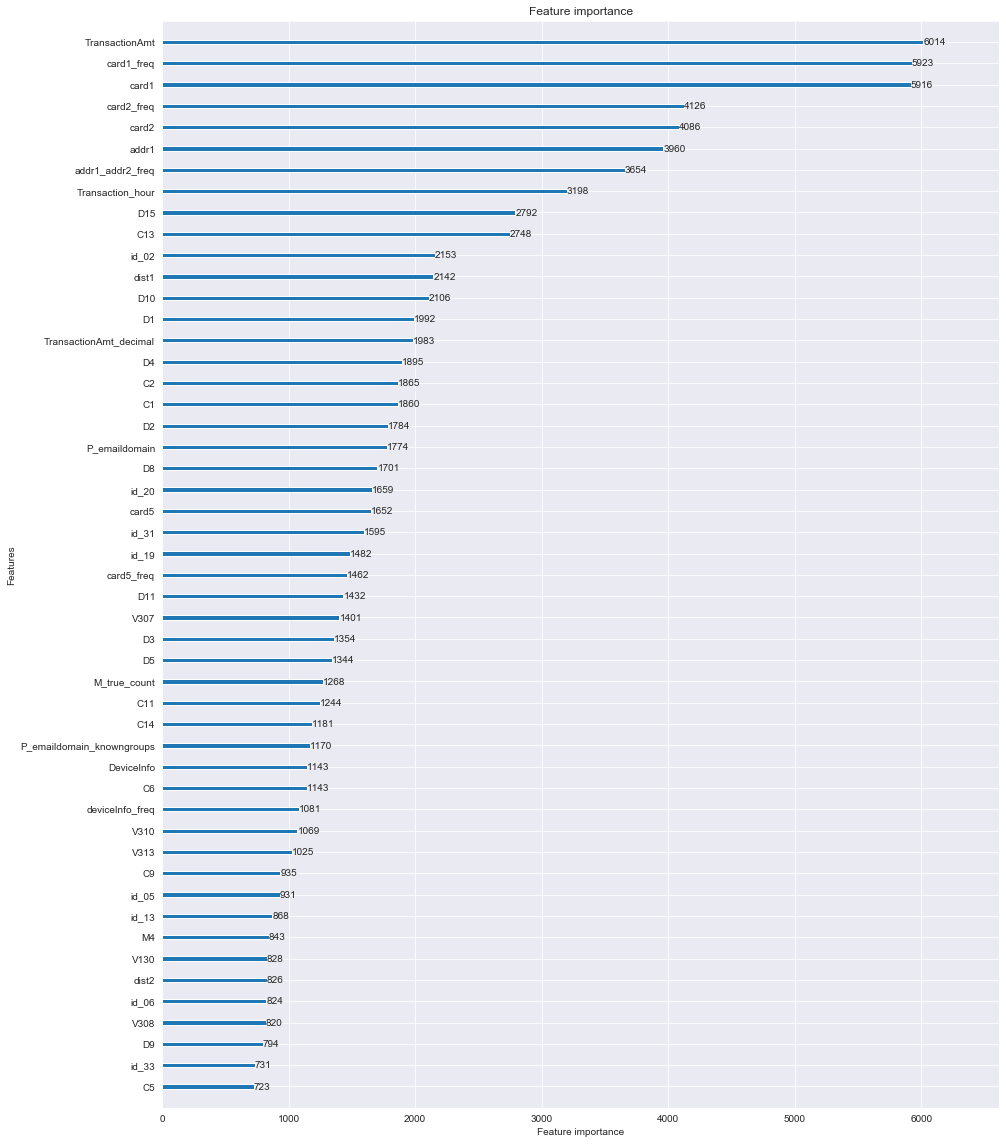

In [65]:
fig, ax = plt.subplots(figsize=(15, 20))
lgb.plot_importance(clf,max_num_features=50,ax=ax)
# for i in range(NFOLDS):
#     fig, ax = plt.subplots(figsize=(15, 20))
#     xgb.plot_importance(clfs[i],max_num_features=50,ax=ax)

In [66]:
sample_submission = pd.read_csv('data/sample_submission.csv', index_col='TransactionID')
sample_submission['isFraud'] = prediction
sample_submission.to_csv('data/lightgbm_CV_holdout_200feat.csv')